In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from keras.callbacks import EarlyStopping

In [3]:
# Read the Excel file:
df = pd.read_excel('Final_LTE.xlsx',index_col="Period start time", parse_dates=True)
df

,LNCEL name,AVE 4G/LTE DL THRPUT (ALL) (KBITS/SEC) FL17A,DL Traffic Volume (GB),UL Traffic Volume(GB),E-UTRAN_Average CQI,PHYSICAL RESOURCE BLOCKS LOAD UL,E-UTRAN Average SINR per Cell for PUSCH,E-UTRAN Average SINR per Cell for PUCCH,TTI sleep over active,Perc UL PRB Util,Avg Latency DL,Avg MCS PDSCH trans.1,RRC_PAGING_REQUESTS (M8008C1),Avg RRC conn UE,DL PRB Utilisation
Period start time,,,,,,,,,,,,,,,
11.06.2023 00:00:00,K_Site_4_22734_1,20526.880000,8.570000,1.060000,9.000000,37.000,-5.0,8.000000,2.370000,41.420000,207.0,14.200000,857680.0,85.090000,98.190000
11.06.2023 00:00:00,K_Site_4_22734_2,7692.040000,1.160000,0.080000,5.000000,3.000,-22.0,-9.000000,4.330000,11.030000,123.0,6.200000,857680.0,10.840000,43.030000
11.06.2023 00:00:00,K_Site_4_22734_3,19009.780000,7.320000,0.800000,9.000000,20.000,-5.0,-9.012541,3.670000,24.750000,121.0,13.100000,857680.0,61.620000,88.720000
11.06.2023 00:00:00,K_Site_4_22734_4,17314.680000,2.060000,0.110000,10.000000,2.000,-21.0,-6.000000,3.870000,10.750000,31.0,14.900000,857672.0,9.520000,28.610000
11.06.2023 01:00:00,K_Site_4_22734_1,22619.720000,9.420000,0.920000,9.000000,31.000,-4.0,14.000000,2.100000,35.490000,227.0,14.300000,686873.0,68.510000,97.850000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-09 20:00:00,R_Site_3_21283_2,12120.627426,3.992341,0.424326,8.953117,86.275,6.0,-7.000000,2.282379,88.684444,132.0,10.663422,1682511.0,65.020000,92.235750
2023-12-09 20:00:00,R_Site_3_21283_3,11721.681079,3.795055,0.333264,8.077929,65.050,6.0,-8.000000,1.986027,68.677208,183.0,9.645148,1682511.0,41.746389,92.084705
2023-12-09 20:00:00,T_Site_3_21283_1,16520.409684,5.107715,0.405675,9.725535,82.400,9.0,-11.000000,2.398527,84.846306,119.0,12.406294,1682511.0,47.383611,83.363865


In [ ]:
# Function to filter rows based on conditions
def filter_rows_for_training(df):
    def check_conditions(row):
        column_name = 'LNCEL name'
        if column_name in df.columns and len(row[column_name]) >= 16:
            condition1 = row[column_name][0] == 'K'
            condition2 = row[column_name][7] == '2'
            condition3 = row[column_name][15] == '3'

            return condition1 and condition2 and condition3
        else:
            return False

    filtered_rows = df[df.apply(check_conditions, axis=1)]
    return filtered_rows

df_filtered = filter_rows_for_training(df)

df_filtered

,LNCEL name,AVE 4G/LTE DL THRPUT (ALL) (KBITS/SEC) FL17A,DL Traffic Volume (GB),UL Traffic Volume(GB),Average CQI,PHYSICAL RESOURCE BLOCKS LOAD UL,E-UTRAN Average SINR per Cell for PUSCH,E-UTRAN Average SINR per Cell for PUCCH,TTI sleep over active,Perc UL PRB Util,Avg Latency DL,Avg MCS PDSCH trans,RRC_PAGING_REQUESTS (M8008C1),Avg RRC conn UE,DL PRB Utilisation
Period start time,,,,,,,,,,,,,,,
2023-11-06 00:00:00,K_Site_2_21260_3,16008.190390,6.700442,1.746367,7.937903,62.9,3.0,5.0,1.366583,66.611764,394,13.171270,857670,162.066944,98.261144
2023-11-06 01:00:00,K_Site_2_21260_3,18425.036798,7.718337,1.495638,8.077941,49.9,3.0,6.0,1.463768,53.989017,329,13.791009,686886,122.161667,98.314708
2023-11-06 02:00:00,K_Site_2_21260_3,21960.614619,9.196483,1.412851,8.422302,44.9,2.0,6.0,2.151179,48.968244,235,14.806429,565354,109.300556,98.198617
2023-11-06 03:00:00,K_Site_2_21260_3,23979.496139,9.561549,0.666618,9.040929,22.3,-3.0,2.0,3.793003,26.833736,144,15.189697,490684,86.149444,91.035539
2023-11-06 04:00:00,K_Site_2_21260_3,19058.859109,6.143886,0.470963,9.706739,19.2,-6.0,1.0,5.007242,23.826044,73,14.711768,473232,70.903333,64.281689
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-16 19:00:00,K_Site_2_21260_3,14913.660240,6.216563,1.502817,7.776198,64.8,2.0,2.0,1.733165,68.753394,271,12.460763,1656841,119.006944,98.320108
2023-12-16 20:00:00,K_Site_2_21260_3,13330.233079,5.528776,1.441006,7.760952,65.9,1.0,3.0,1.578531,69.842700,295,11.968591,1587619,127.350556,98.006394
2023-12-16 21:00:00,K_Site_2_21260_3,14468.679184,5.999688,1.872412,7.738249,75.0,3.0,5.0,1.447717,78.535467,308,12.396211,1446894,133.196389,98.068364


<Axes: xlabel='Period start time'>

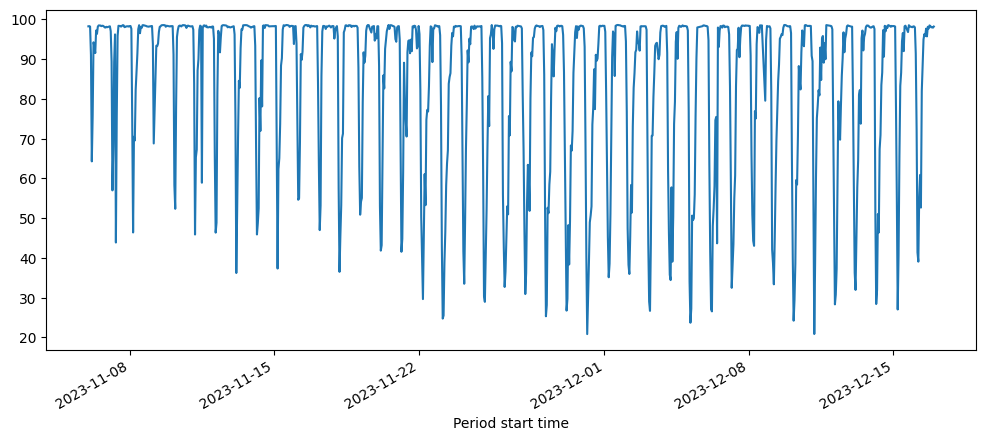

In [ ]:
PRB = df_filtered['DL PRB Utilisation']
PRB.plot(figsize=(12,5))

In [ ]:
def create_sequences(df, column_name, sequence_length):
    sequence_as_np = df[column_name].to_numpy()
    X = []
    y = []

    for i in range(len(sequence_as_np) - sequence_length):
        row = [[a] for a in sequence_as_np[i:i + sequence_length]]
        X.append(row)
        label = sequence_as_np[i + sequence_length]
        y.append(label)

    return np.array(X), np.array(y)

In [ ]:
# Example usage with your PRB sequence
SEQUENCE_LENGTH = 24
X, y = create_sequences(df_filtered, 'DL PRB Utilisation', SEQUENCE_LENGTH)

In [ ]:
input = 778
X_train, y_train = X[:input], y[:input]
X_test, y_test = X[input:], y[input:]
X_train.shape, y_train.shape , X_test.shape, y_test.shape

((778, 24, 1), (778,), (168, 24, 1), (168,))

In [ ]:
# Create MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the data
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).reshape(y_train.shape)
X_test_scaled = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_test_scaled = scaler.fit_transform(y_test.reshape(-1, 1)).reshape(y_test.shape)

In [ ]:
# Build the model with scaled data
model = Sequential()
model.add(GRU(units=100, activation='relu', return_sequences=False, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(units=1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Train the model with scaled data and early stopping
model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=16, validation_split=0.1, callbacks=[early_stopping])

NameError: name 'X_train_scaled' is not defined

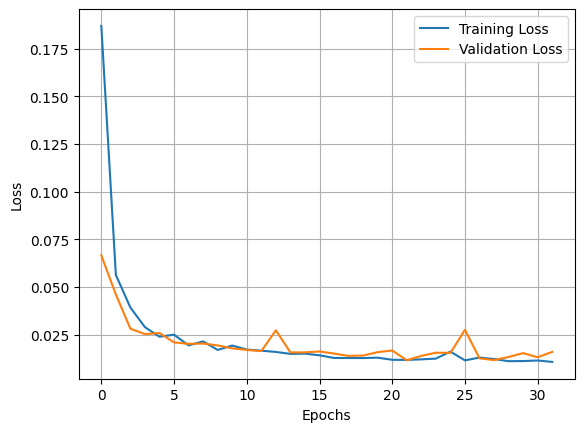

In [ ]:
# Plot the loss per epoch
loss_per_epoch = model.history.history['loss']
val_loss_per_epoch = model.history.history['val_loss']

plt.plot(range(len(loss_per_epoch)), loss_per_epoch, label='Training Loss')
plt.plot(range(len(val_loss_per_epoch)), val_loss_per_epoch, label='Validation Loss')
plt.legend()
plt.grid(True)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

6/6 [==============================] - 0s 9ms/step
Mean Squared Error on Test Set: 68.56448807494706
Root Mean Squared Error on Test Set: 8.280367629214723
Mean Absolute Error on Test Set: 5.422303741989656
Mean Absolute Percentage Error on Test Set: 9.33%
R-squared on Test Set: 0.8539230633458077


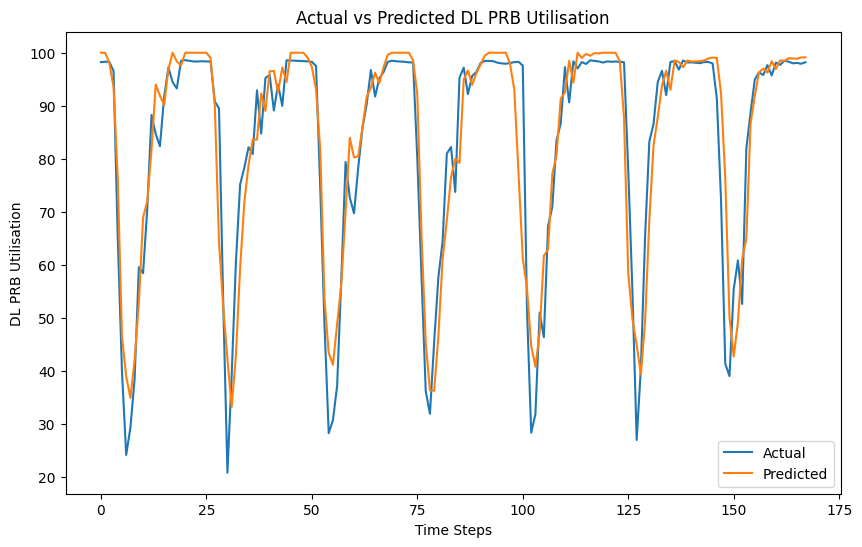

In [ ]:
# Make predictions on the test set
y_pred_scaled = model.predict(X_test_scaled)

# Inverse transform the predictions to the original scale
y_pred = scaler.inverse_transform(y_pred_scaled)

# Reshape predictions and true labels to match the original shape
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

# Clip the predictions to ensure they don't exceed 100
y_pred = np.clip(y_pred, 0, 100)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)

print(f'Mean Squared Error on Test Set: {mse}')
print(f'Root Mean Squared Error on Test Set: {rmse}')
print(f'Mean Absolute Error on Test Set: {mae}')
print(f'Mean Absolute Percentage Error on Test Set: {mape * 100:.2f}%')
print(f'R-squared on Test Set: {r_squared}')

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted DL PRB Utilisation')
plt.xlabel('Time Steps')
plt.ylabel('DL PRB Utilisation')
plt.legend()
plt.show()

In [ ]:
test_results = pd.DataFrame(data={'Actuals':y_test, 'Test Predictions':y_pred})
test_results

,Actuals,Test Predictions
0,98.233822,100.000000
1,98.295703,100.000000
2,98.294161,98.116058
3,96.550353,93.518288
4,65.086106,76.352097
...,...,...
163,98.320108,98.964241
164,98.006394,98.913857
165,98.068364,98.857292
166,97.925603,99.103706


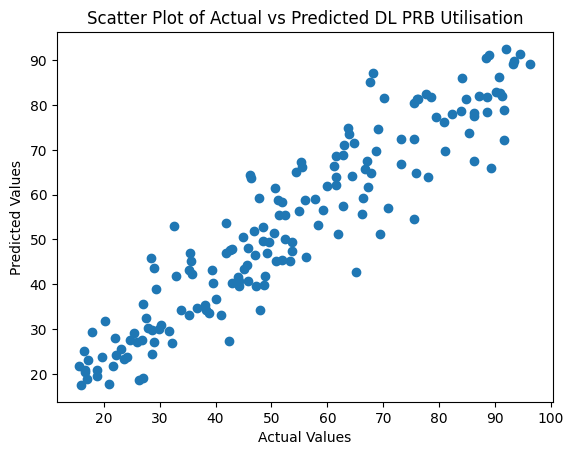

In [ ]:
plt.scatter(y_test, y_pred)
plt.title('Scatter Plot of Actual vs Predicted DL PRB Utilisation')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

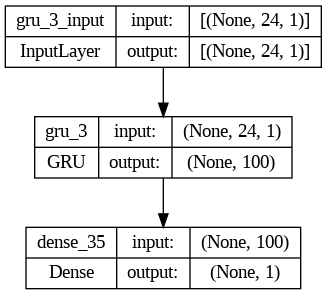

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 100)               40800     
                                                                 
 dense_36 (Dense)            (None, 1)                 101       
                                                                 
Total params: 40901 (159.77 KB)
Trainable params: 40901 (159.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
